In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
def calculate_amihud_liquidity(cleansed):
    volume=load_daily_volume()
    contract_size=load_maps()
    fx=load_fx()
    fx_map=contract_size.to_dict()['Currency']
    tick_map=contract_size.to_dict()['Tick Value']
    fx=fx.resample(rule='d',how='last')
    px=cleansed.resample(rule='d',how='last')
    total_vol=pd.DataFrame()
    for m in cleansed.columns:
        try:
            curr= str(fx_map[m])
            total_vol[m] = (px[m]/fx[curr]*volume[m]*tick_map[m])[:'2016'] 
        except:
            print(m)
    x= (cleansed.pct_change().abs()/ total_vol).resample(rule='m',how='median')
    return x.replace([np.inf, -np.inf,0], np.nan)

In [4]:
cleansed=pd.read_csv('extra_px_ammended.csv',parse_dates=['Date'],index_col=0)

In [5]:
v=pd.read_csv('extra_vol.csv',parse_dates=['Date'],index_col=0)
#volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')
volume=v

In [6]:
v=v.mask(v < 500, np.nan)

In [7]:
#volume=load_daily_volume()
contract_size=load_maps()
fx=load_fx()
fx_map=contract_size.to_dict()['Currency']
tick_map=contract_size.to_dict()['Tick Value']
fx=fx.resample(rule='d',how='last')
px=cleansed.resample(rule='d',how='last')
total_vol=pd.DataFrame()
for m in cleansed.columns:
    try:
        curr= str(fx_map[m])
        #total_vol[m] = (px[m]/fx[curr]*v[m]*tick_map[m])[:'2016'] 
        t = (px[m]/fx[curr]*volume[m]*tick_map[m])[:'2016'] 
        t[t<5e7] = np.nan
        total_vol[m]=t
    except:
        print(m)
x= (cleansed.pct_change().abs()/ total_vol).resample(rule='m',how='median')


    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()


In [8]:
amihud=x.dropna(how='all')

In [9]:
amihud=x.replace([np.inf, -np.inf,0], np.nan)

In [ ]:
def quantile_portfolios_annual_month_check(rank_data,price_data,number_of_buckets=10):
    deciles={}
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
    for y in range(rank_data.index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            #checks to make sure there are 12 months for the contact
            ind=rank_data[str(y)].count()==12
            temp=rank_data.T[ind].T
            mkts=quantile_columns(temp.resample(rule='a',how='median'),year,number_of_buckets,i)
            rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
    return pd.DataFrame(deciles)

In [ ]:

def quantile_portfolios_monthly(rank_data,price_data,number_of_buckets=10):
    deciles={}
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
    for y in range(rank_data.index[0].year+1,rank_data.index[-1].year,1):
        for m in range(1,13,1):
            mon=str(y)+'-'+str(m)
            for i in range(0,number_of_buckets,1):
                mkts=quantile_columns_monthly(rank_data.resample(rule='m',how='median'),mon,number_of_buckets,i)
                y_temp= y
                m_temp=m+1
                if m==12:
                    y_temp=y+1
                    m_temp=1
                next_mon = str(y_temp)+'-'+str(m_temp)
                rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[next_mon].mean(axis=1)
                deciles[str(i)]=deciles[str(i)].append(rtns)
    return pd.DataFrame(deciles)

In [10]:
temp=sector_XS_normalized(amihud['2000':'2016'],with_equity=True)

In [11]:
sector_zscores={}
for s in temp.keys():
    if len(temp[s]):
        sector_zscores[s]=temp[s]

In [59]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual_month_check(sector_zscores[s],cleansed,3)
#sector_portfolio_sorts['All']=quantile_portfolios_annual_month_check(amihud,cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if sys.path[0] == '':


In [60]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']

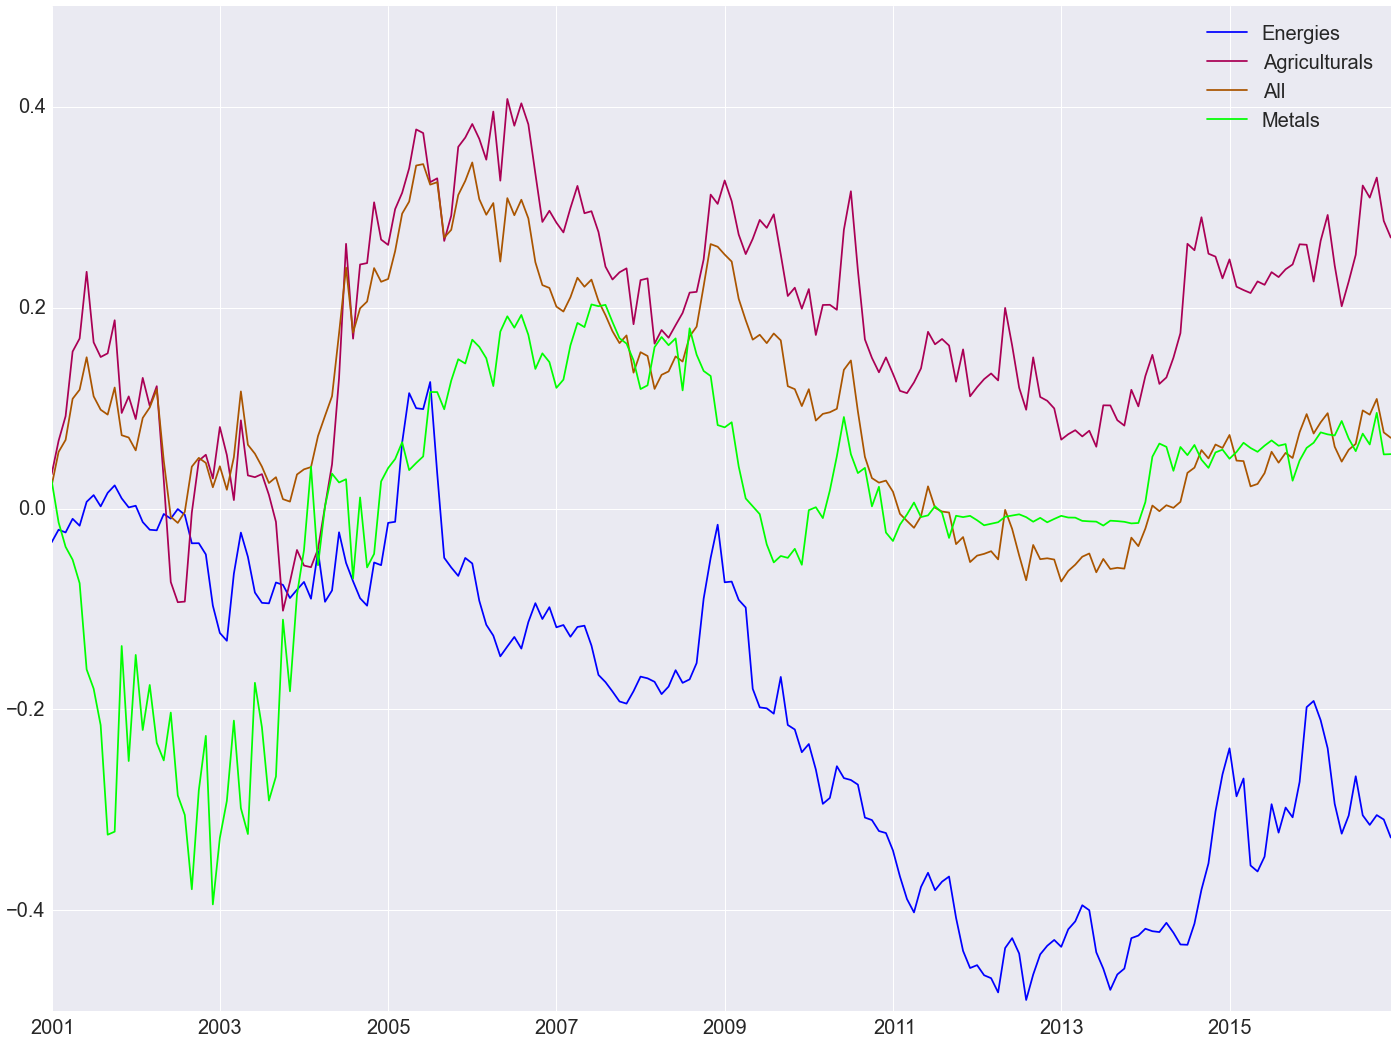

In [62]:
factors['2000':'2016'].cumsum().plot(colormap='brg')

# FHT annual


In [70]:
FHT_extra=calculate_FHT(cleansed)

In [77]:
temp=sector_XS_normalized(FHT_extra['2000':'2016'],with_equity=True)

In [78]:
sector_zscores={}
for s in temp.keys():
    if len(temp[s]):
        sectors_FHT[s]=temp[s]

In [79]:
sector_portfolio_sorts_FHT={}
for s in sectors_FHT.keys():
    sector_portfolio_sorts_FHT[s]=quantile_portfolios_annual_month_check(sectors_FHT[s],cleansed,3)
#sector_portfolio_sorts_FHT['All']=quantile_portfolios_annual(FHT_extra,cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if sys.path[0] == '':


In [80]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts_FHT[s]['2']-sector_portfolio_sorts_FHT[s]['0']

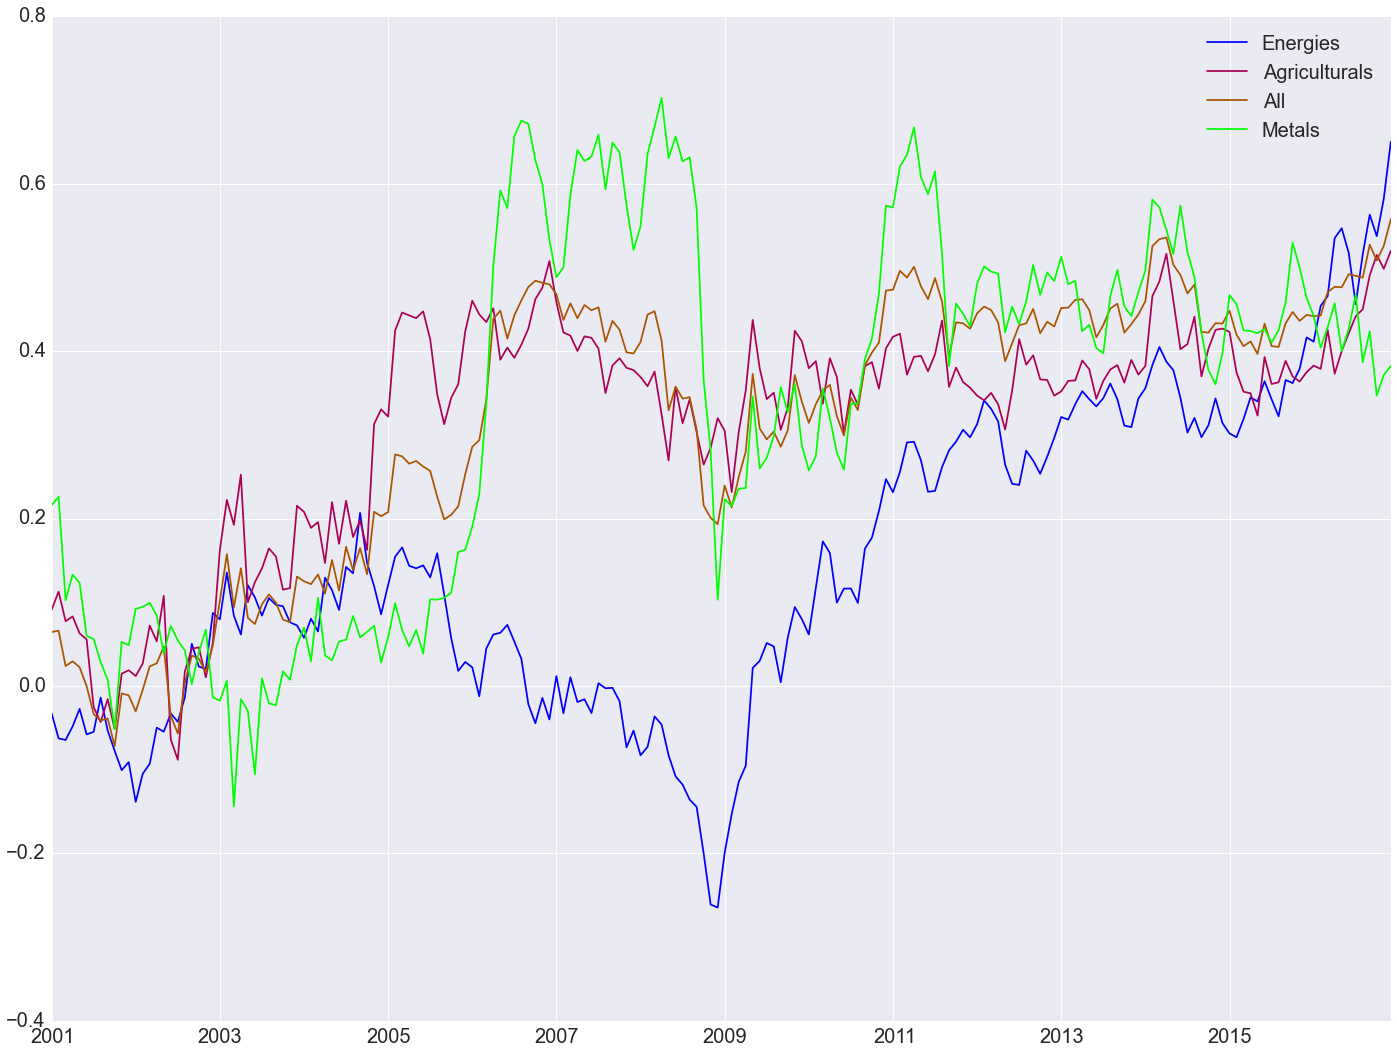

In [81]:
factors_FHT.cumsum().plot(colormap='brg')